In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import numpy as np
import re

In [16]:
df = pd.read_csv("C:\\Users\\ancha\\OneDrive\\Desktop\\house_price.csv")

In [17]:
df = df[["sqft", "No. of room", "bath", "total_sqft", "location", "price"]]

In [18]:
# 3. Clean total_sqft Column
def convert_sqft(x):
    try:
        # If range like "2100 - 2850"
        if "-" in str(x):
            parts = x.split("-")
            return (float(parts[0]) + float(parts[1])) / 2
        # If just a number
        return float(x)
    except:
        # If contains non-numeric (e.g., "34.5Sq. Meter"), extract number part
        match = re.findall(r"[\d\.]+", str(x))
        if match:
            return float(match[0])
        return np.nan

In [19]:
df["total_sqft"] = df["total_sqft"].apply(convert_sqft)

In [20]:
# 4. Handle Missing Values
print("Missing values before:\n", df.isnull().sum())

Missing values before:
 sqft             0
No. of room    608
bath            73
total_sqft       0
location         0
price            0
dtype: int64


In [21]:
# Fill numeric NaN with median
num_imputer = SimpleImputer(strategy="median")
df[["sqft", "No. of room", "bath", "total_sqft"]] = num_imputer.fit_transform(
    df[["sqft", "No. of room", "bath", "total_sqft"]]
)


In [22]:
# Fill categorical NaN with most frequent
cat_imputer = SimpleImputer(strategy="most_frequent")
df[["location"]] = cat_imputer.fit_transform(df[["location"]])


In [23]:
print("Missing values after:\n", df.isnull().sum())

Missing values after:
 sqft           0
No. of room    0
bath           0
total_sqft     0
location       0
price          0
dtype: int64


In [24]:
# 5. Remove Outliers

upper_price = df['price'].quantile(0.99)   # remove top 1% extreme prices
upper_sqft = df['sqft'].quantile(0.99)     # remove top 1% sqft outliers


In [25]:
df = df[(df['price'] <= upper_price) & (df['sqft'] <= upper_sqft)]

In [26]:
print("Dataset after outlier removal:", df.shape)

Dataset after outlier removal: (13102, 6)


In [27]:
# 6. Prepare Data
X = df[["sqft", "No. of room", "bath", "total_sqft", "location"]]
y = df["price"]

In [28]:
num_features = ["sqft", "No. of room", "bath", "total_sqft"]
cat_features = ["location"]


In [29]:
# Preprocessor: scale numeric + encode categorical
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(drop="first"), cat_features)
])

In [30]:
X_processed = preprocessor.fit_transform(X)

In [31]:
# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)


In [34]:
# 8. Train RandomForest Model
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

In [35]:
# 9. Evaluate Model
y_pred = model.predict(X_test)


In [36]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [37]:

print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

Root Mean Squared Error (RMSE): 50.606997065914534
R² Score: 0.6596513959327988


In [38]:
# Compare predictions
results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print(results.head(10))

       Actual   Predicted
4417   215.00   61.663552
7852   120.00   95.594913
3603   148.00  146.566367
1262   120.00  141.970300
731     52.00   57.121686
8659   160.00   47.658661
9465    35.00   49.530150
10074  280.00  206.974350
1772   124.00  258.915525
2493    91.72   69.413817


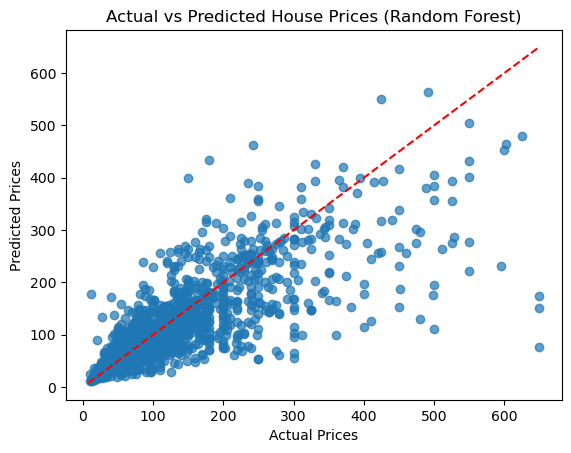

In [39]:
# 10. Visualization
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices (Random Forest)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")
plt.show()


In [40]:
# 11. Feature Importance
feature_names = preprocessor.get_feature_names_out()
importances = model.feature_importances_


In [41]:
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)
print("\nFeature Importances:\n", feat_imp)


Feature Importances:
                                                Feature  Importance
0                                            num__sqft    0.468614
2                                            num__bath    0.121402
3                                      num__total_sqft    0.119012
962                         cat__location_Rajaji Nagar    0.015638
1                                     num__No. of room    0.015231
..                                                 ...         ...
18                    cat__location_1 Ramamurthy Nagar    0.000000
806                     cat__location_Meenakshi Layout    0.000000
117  cat__location_Ananthanagar Phase 1,Electronic ...    0.000000
19   cat__location_12th cross srinivas nagar bansha...    0.000000
122                  cat__location_Anekal - Hosur Road    0.000000

[1285 rows x 2 columns]
